In [1]:
import numpy as np
import matplotlib.pyplot as plt

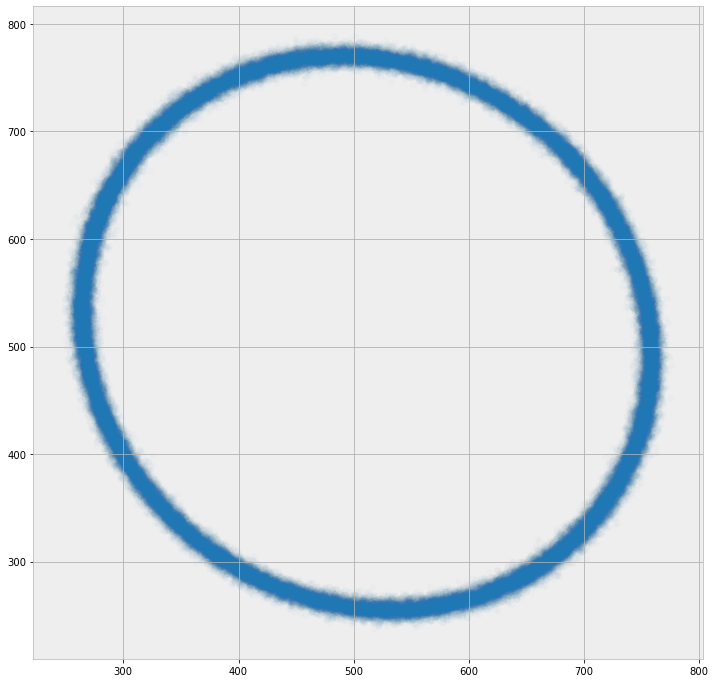

In [113]:
# Make test data
# (x,y points)

L = 1024
N = 100000

x0 = 511
y0 = 513
A = 240
B = 264
phi = np.radians(32)

sigma_r = 0.02

# Define coords
yy,xx = np.meshgrid(np.arange(L),np.arange(L))

# Define datapoints in (r,theta)
theta = np.random.uniform(0,2*np.pi,N)
r = np.random.normal(1,sigma_r,size=N)

# Get points in (x,y)
x = x0 + A*r*np.cos(theta)*np.cos(phi) - B*r*np.sin(theta)*np.sin(phi)
y = y0 + B*r*np.sin(theta)*np.cos(phi) + A*r*np.cos(theta)*np.sin(phi)

# Show
fig,ax = plt.subplots(figsize=(12,12))
ax.scatter(x,y,alpha=0.02)
plt.show()

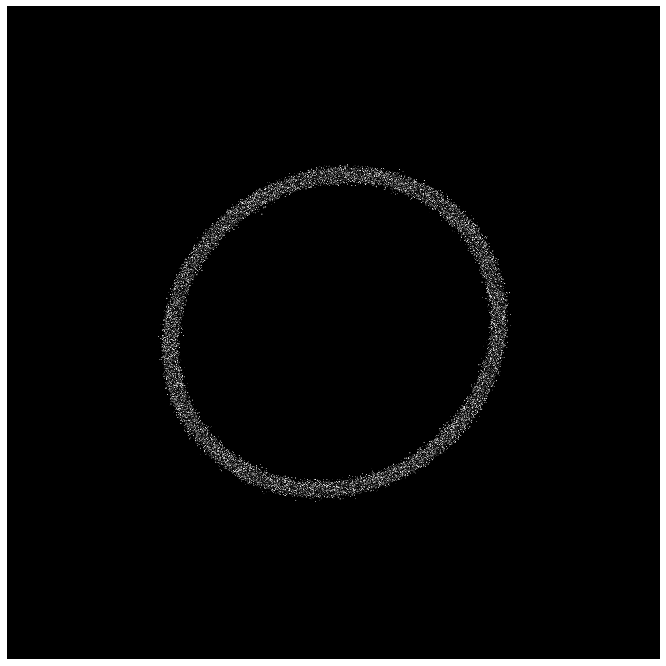

In [114]:
# Make test data
# (data array)

data = np.zeros((L,L))

xF,yF = np.floor(x),np.floor(y)
dx,dy = x-xF,y-yF
weights = np.hstack(((1-dx)*(1-dy),
                     (1-dx)*(  dy),
                     (  dx)*(1-dy),
                     (  dx)*(  dy)))
x_inds = np.hstack((xF,xF,xF+1,xF+1))
y_inds = np.hstack((yF,yF+1,yF,yF+1))

data[x_inds.astype(int),y_inds.astype(int)] += weights

# Show
fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(data,cmap='gray')
ax.axis('off')
plt.show()

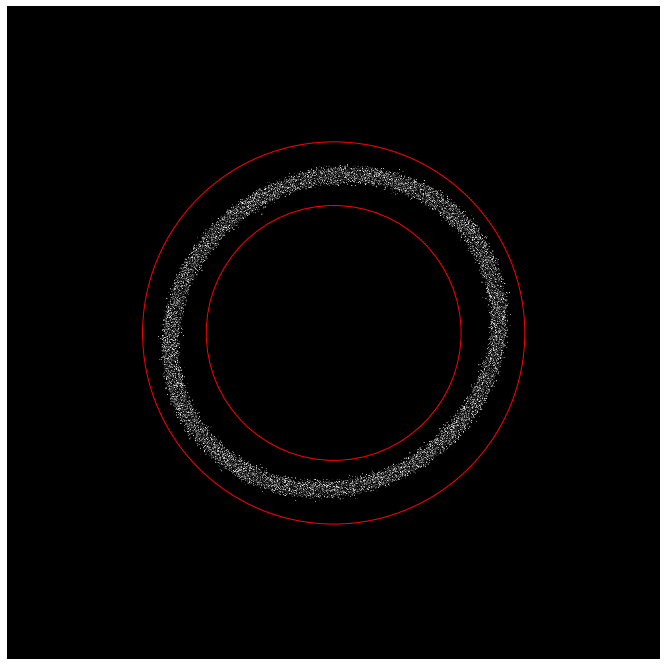

In [115]:
# Overlay an annulus

from matplotlib.patches import Circle, Ellipse

xc,yc = 512,512
r_inner = 200
r_outer = 300

# Show
circ_inner = Circle((yc,xc),r_inner,fill=None,color='r',lw=1)
circ_outer = Circle((yc,xc),r_outer,fill=None,color='r',lw=1)
fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(data,cmap='gray')
ax.add_patch(circ_inner)
ax.add_patch(circ_outer)
ax.axis('off')
plt.show()

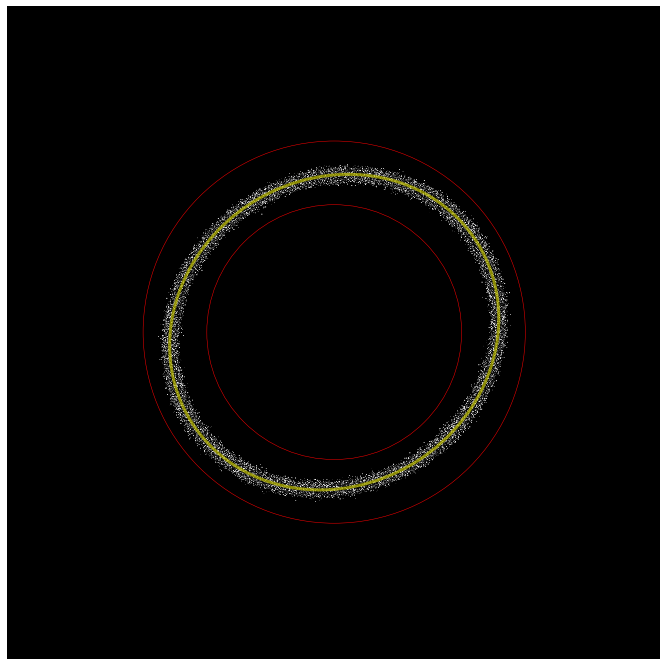

In [116]:
# Fit an ellipse

from py4DSTEM.process.calibration import measure_elliptical_distortion

ellipse_params,_ = measure_elliptical_distortion(data, xc, yc, r_inner, r_outer)
x0_,y0_,A_,B_,phi_ = ellipse_params

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(data,cmap='gray')
circle_inner = Circle((y0_,x0_),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0_,x0_),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y0_,x0_),2*A_,2*B_,90-np.degrees(phi_), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
ax.axis('off')
plt.show()

In [117]:
print("{:.2f}% error in x0".format(100*(x0-x0_)/x0_))
print("{:.2f}% error in y0".format(100*(y0-y0_)/y0_))
print("{:.2f}% error in A".format(100*(A-A_)/A_))
print("{:.2f}% error in B".format(100*(B-B_)/B_))
print("{:.2f}% error in phi".format(100*(phi-phi_)/phi_))
r_ab,r_ab_ = float(A)/B, A_/B_
print("{:.2f}% error in A/B".format(100*(r_ab-r_ab_)/r_ab_))

0.06% error in x0
0.03% error in y0
-0.30% error in A
-0.32% error in B
0.27% error in phi
0.02% error in A/B


### Elliptical data application 1: Polar Elliptical transform

Electron diffraction patterns will, as a general rule, contain some elliptical distortions.  A polar-elliptical transformation -- resampling the data into a polar-elliptical coordinate system -- can effectively correct these distortions, given the right selection of ellipse.

In [122]:
from py4DSTEM.process.utils import cartesianDataAr_to_polarEllipticalDataAr

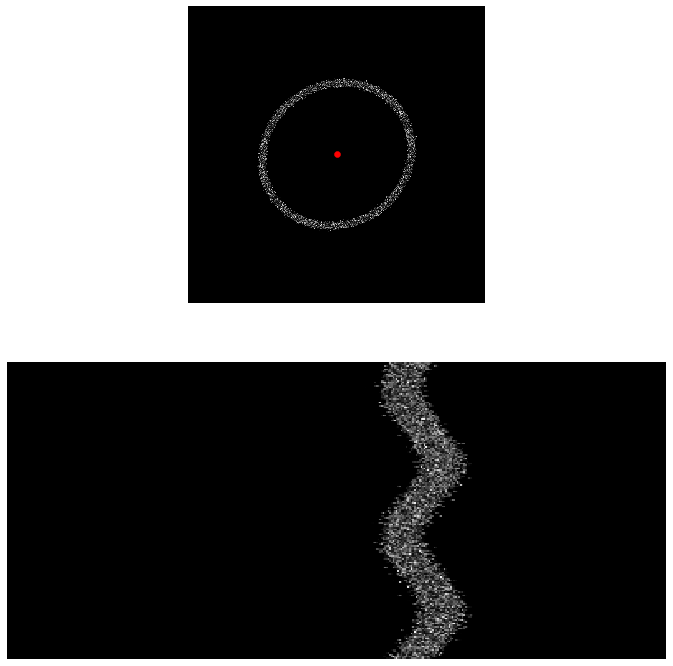

In [123]:
# Polar transform (i.e. A=B)
ellipse_params = (x0_,y0_,1,1,0)

polarData,rr,tt = cartesianDataAr_to_polarEllipticalDataAr(
                    cartesianData=data,
                    params=ellipse_params,
                    dr=1,
                    r_range=400,
                    dtheta=np.radians(2),
                    mask=None
)

# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.matshow(data)
ax1.scatter(y0_,x0_,color='r')
ax2.matshow(polarData.data)
ax1.axis('off')
ax2.axis('off')
plt.show()

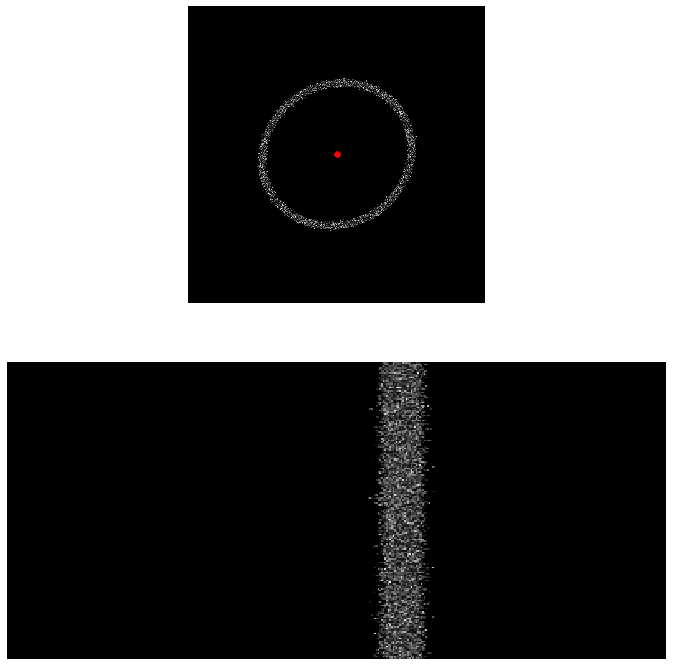

In [155]:
# Polar-elliptical transform

ellipse_params = (x0_,y0_,1,B_/A_,phi_)

polarData,rr,tt = cartesianDataAr_to_polarEllipticalDataAr(
                    cartesianData=data,
                    params=ellipse_params,
                    dr=1,
                    r_range=400,
                    dtheta=np.radians(2),
                    mask=None
)

# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.matshow(data)
ax1.scatter(y0_,x0_,color='r')
ax2.matshow(polarData.data)
ax1.axis('off')
ax2.axis('off')
plt.show()

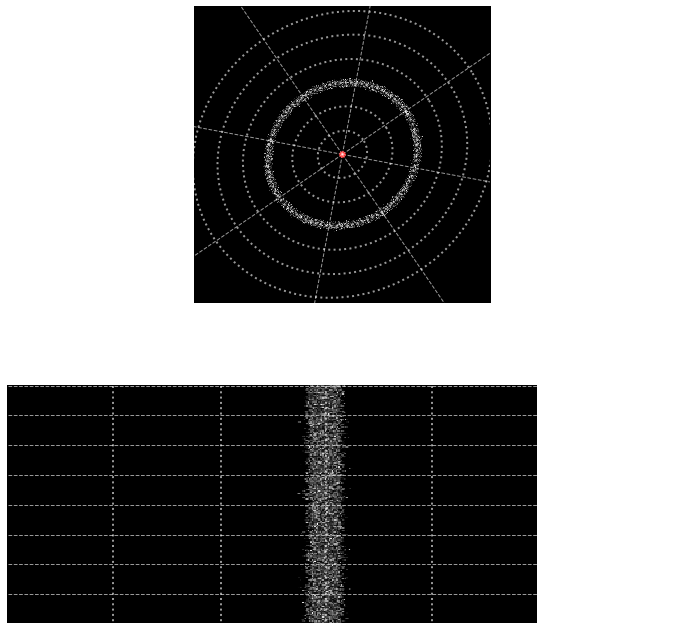

In [179]:
# Polar-elliptical transform, with coordinate lines

r_vals = [0.33,0.67,1,1.33,1.67,2]
ellipses = []
for i,r_val in enumerate(r_vals):
    ellipse = Ellipse((y0_,x0_),r_val*2*A_,r_val*2*B_,90-np.degrees(phi_), fill=False,ec='w',ls=":",lw=2, alpha=.6)
    ellipses.append(ellipse)

def get_xfyf(x0,y0,theta,phi):
    R = 600
    xf = x0 + A_*R*np.cos(theta)*np.cos(phi) - B_*R*np.sin(theta)*np.sin(phi)
    yf = y0 + B_*R*np.cos(theta)*np.sin(phi) + A_*R*np.sin(theta)*np.cos(phi)
    return xf,yf

Nt,Nr = polarData.data.shape
    
# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.matshow(data)
ax1.scatter(y0_,x0_,color='r')
for ellipse in ellipses:
    ax1.add_patch(ellipse)
for theta in np.linspace(0,2*np.pi,8,endpoint=False):
    xf,yf = get_xfyf(x0_,y0_,theta,phi_)
    ax1.plot((y0_,yf),(x0_,xf),color='w',lw=1,ls='--',alpha=0.6)
ax1.matshow(data)
ax1.axis('off')

ax2.matshow(polarData.data)
ax2.hlines(np.linspace(0,Nt,8,endpoint=False),0,Nr,color='w',lw=1,ls='--',alpha=0.6)
ax2.vlines(np.array(r_vals)*A_,0,Nt,color='w',ls=":",lw=2, alpha=0.6)
ax2.axis('off')
plt.show()

In [121]:
# Elliptical data application 2: Elliptical distortion correction to Bragg peak positions
# Show: bragg vector map, before/after

In [59]:
# Elliptical data application 3: FEM

In [ ]:
# Elliptical data application 4: RDF

In [60]:
# Elliptical data application 3: Amorphous strain
# - measure the ellipse of an amorphous ring, by scan position
# - convert ellipse params to e_xx,e_yy,theta

In [61]:
# Masks
# Masks for fitting
# Masked transforms